# Exploratory Data Analysis – Sierra Leone

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
sns.set(style="whitegrid")


In [ ]:

df = pd.read_csv("../data/sierraleone-bumbuna.csv")
print(df.shape)
df.head()


In [16]:

from scipy import stats
import numpy as np

#  Drop empty Comments column
df = df.drop(columns=["Comments"], errors="ignore")

#  Replace negative irradiance values with NaN
irr_cols = ["GHI", "DNI", "DHI"]
for col in irr_cols:
    df.loc[df[col] < 0, col] = np.nan

#  Impute missing values using median
for col in irr_cols:
    df[col] = df[col].fillna(df[col].median())

#  Compute Z-scores for key numeric columns
num_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
z = np.abs(stats.zscore(df[num_cols], nan_policy="omit"))

# 5️⃣ Filter rows where all Z-scores < 3
df_clean = df[(z < 3).all(axis=1)]

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)


Original shape: (525600, 18)
Cleaned shape: (503476, 18)


In [17]:
df_clean.to_csv("../data/sierra_leone_clean.csv", index=False)
print("✅ Sierra Leone cleaned dataset saved locally.")


✅ Sierra Leone cleaned dataset saved locally.


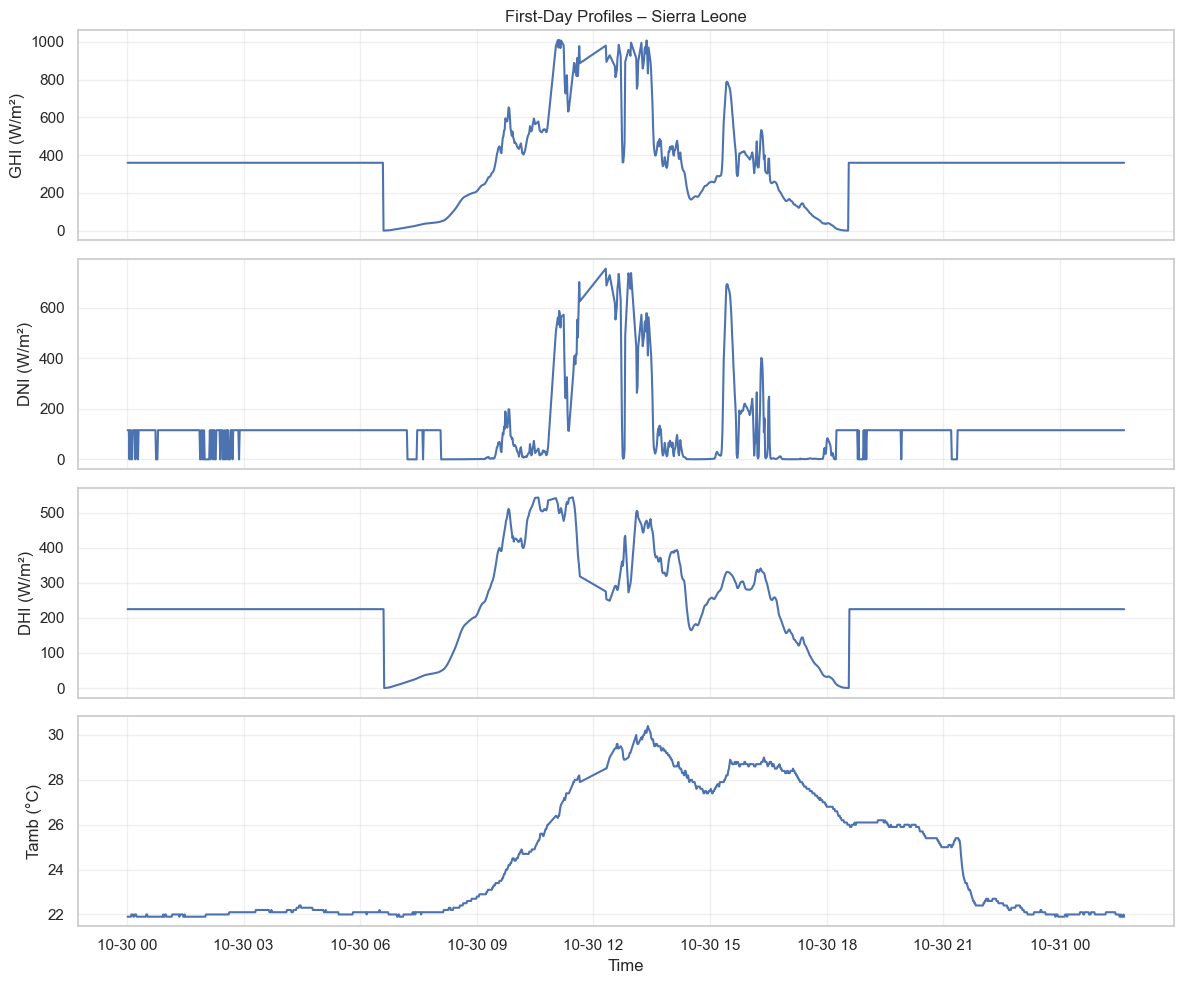

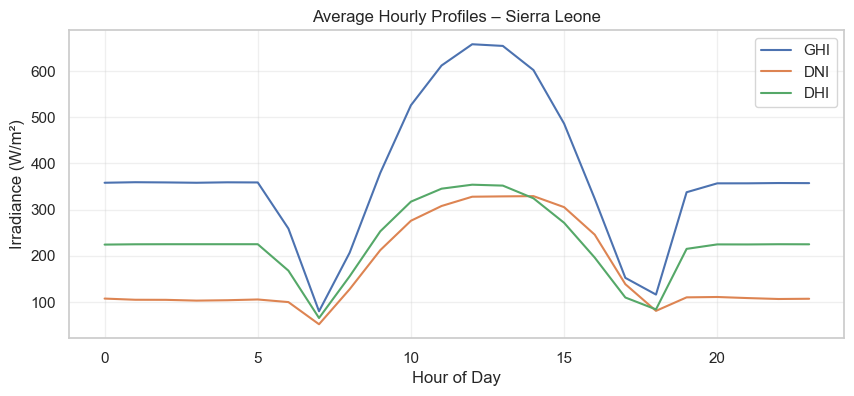

In [18]:
#time series plot
import matplotlib.pyplot as plt
import seaborn as sns

# Use the cleaned frame from your previous step
df_clean = df_clean.copy()
df_clean["Timestamp"] = pd.to_datetime(df_clean["Timestamp"])
df_clean = df_clean.sort_values("Timestamp")

# --- 24h window (first day)
day_slice = df_clean.iloc[:1440]  # first 24h (minute-level)

fig, axes = plt.subplots(4, 1, figsize=(12,10), sharex=True)
axes[0].plot(day_slice["Timestamp"], day_slice["GHI"]); axes[0].set_ylabel("GHI (W/m²)")
axes[1].plot(day_slice["Timestamp"], day_slice["DNI"]); axes[1].set_ylabel("DNI (W/m²)")
axes[2].plot(day_slice["Timestamp"], day_slice["DHI"]); axes[2].set_ylabel("DHI (W/m²)")
axes[3].plot(day_slice["Timestamp"], day_slice["Tamb"]); axes[3].set_ylabel("Tamb (°C)")
axes[0].set_title("First-Day Profiles – Sierra Leone")
axes[-1].set_xlabel("Time")
for ax in axes: ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# --- Hour-of-day averages (full year)
df_clean["hour"] = df_clean["Timestamp"].dt.hour
hourly = df_clean.groupby("hour")[["GHI","DNI","DHI","Tamb"]].mean()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(hourly.index, hourly["GHI"], label="GHI")
ax.plot(hourly.index, hourly["DNI"], label="DNI")
ax.plot(hourly.index, hourly["DHI"], label="DHI")
ax.set_title("Average Hourly Profiles – Sierra Leone")
ax.set_xlabel("Hour of Day"); ax.set_ylabel("Irradiance (W/m²)")
ax.grid(True, alpha=0.3); ax.legend()
plt.show()


##  Cleaning Impact (Pre vs Post)
Average ModA & ModB grouped by the `Cleaning` flag.


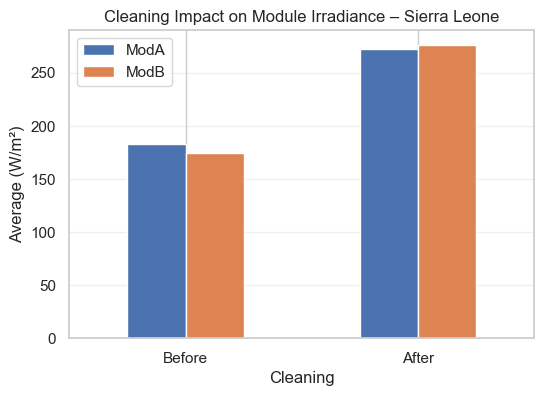

In [14]:
if {"Cleaning","ModA","ModB"}.issubset(df_clean.columns):
    df_clean.groupby("Cleaning")[["ModA","ModB"]].mean().plot(kind="bar", figsize=(6,4))
    plt.title("Cleaning Impact on Module Irradiance – Sierra Leone")
    plt.ylabel("Average (W/m²)"); plt.xticks([0,1], ["Before","After"], rotation=0)
    plt.grid(True, axis='y', alpha=0.3); plt.show()
else:
    print("Skip: Cleaning/ModA/ModB not all found.")


##  Correlations & Relationships
Heatmap among irradiance and module temps; scatter relationships.


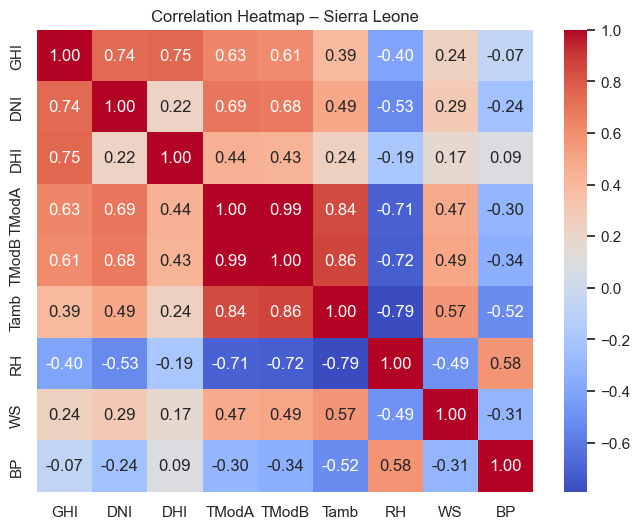

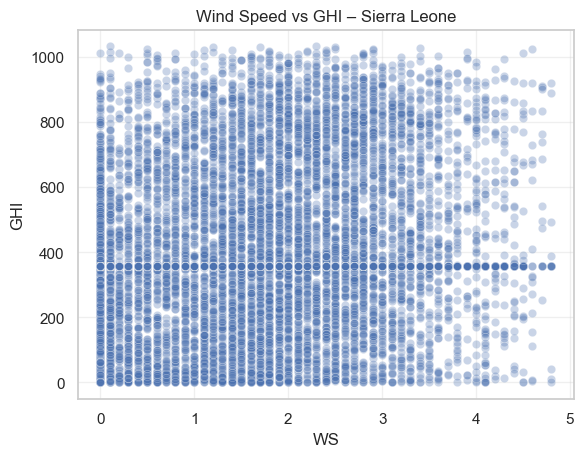

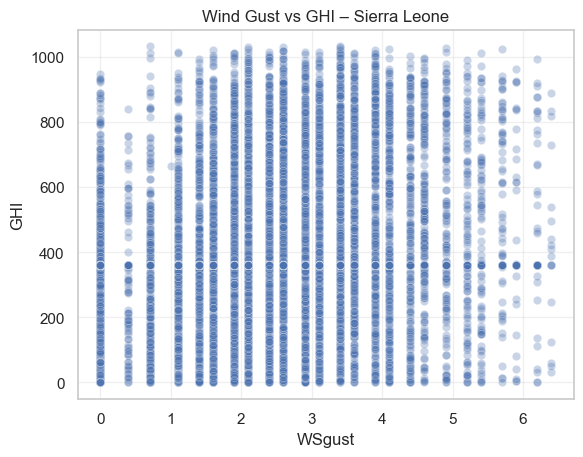

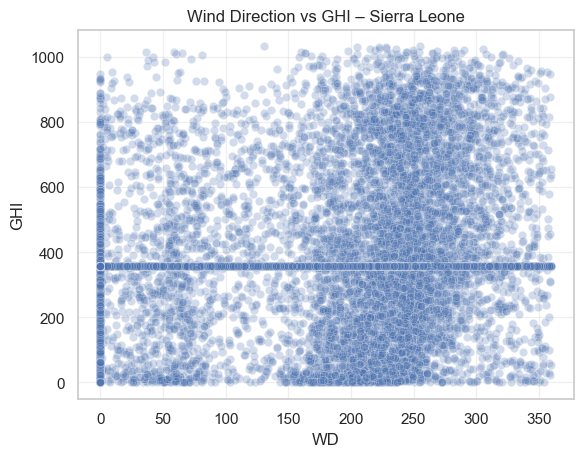

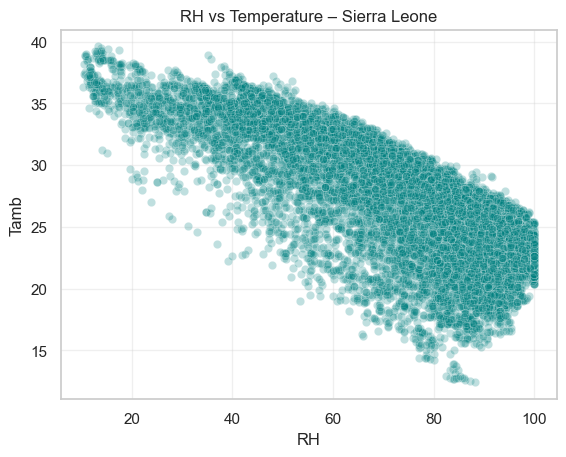

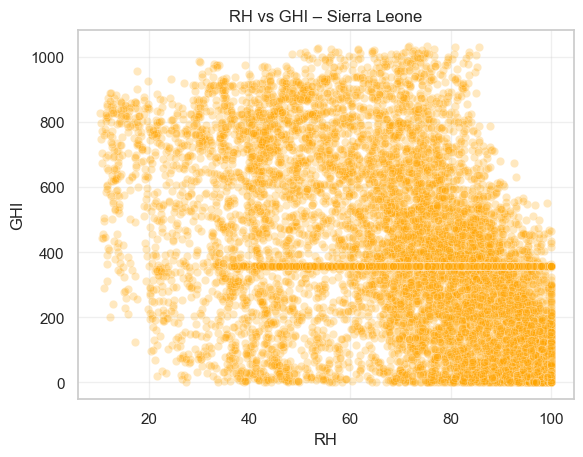

In [15]:
corr_cols = [c for c in ["GHI","DNI","DHI","TModA","TModB","Tamb","RH","WS","BP"] if c in df_clean.columns]
if corr_cols:
    plt.figure(figsize=(8,6))
    sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap – Sierra Leone"); plt.show()

# Wind vs GHI
if {"WS","GHI"}.issubset(df_clean.columns):
    sns.scatterplot(x="WS", y="GHI", data=df_clean.sample(n=min(20000, len(df_clean)), random_state=42), alpha=0.3)
    plt.title("Wind Speed vs GHI – Sierra Leone"); plt.grid(True, alpha=0.3); plt.show()

# Wind gust vs GHI
if {"WSgust","GHI"}.issubset(df_clean.columns):
    sns.scatterplot(x="WSgust", y="GHI", data=df_clean.sample(n=min(20000, len(df_clean)), random_state=42), alpha=0.3)
    plt.title("Wind Gust vs GHI – Sierra Leone"); plt.grid(True, alpha=0.3); plt.show()

# Wind direction vs GHI
if {"WD","GHI"}.issubset(df_clean.columns):
    sns.scatterplot(x="WD", y="GHI", data=df_clean.sample(n=min(20000, len(df_clean)), random_state=42), alpha=0.25)
    plt.title("Wind Direction vs GHI – Sierra Leone"); plt.grid(True, alpha=0.3); plt.show()

# Humidity vs Temperature or vs GHI
if {"RH","Tamb"}.issubset(df_clean.columns):
    sns.scatterplot(x="RH", y="Tamb", data=df_clean.sample(n=min(20000, len(df_clean)), random_state=42), alpha=0.25, color="teal")
    plt.title("RH vs Temperature – Sierra Leone"); plt.grid(True, alpha=0.3); plt.show()
if {"RH","GHI"}.issubset(df_clean.columns):
    sns.scatterplot(x="RH", y="GHI", data=df_clean.sample(n=min(20000, len(df_clean)), random_state=42), alpha=0.25, color="orange")
    plt.title("RH vs GHI – Sierra Leone"); plt.grid(True, alpha=0.3); plt.show()


## Wind & Distributions
Histograms for GHI and WS; wind direction polar distribution (wind rose-style).


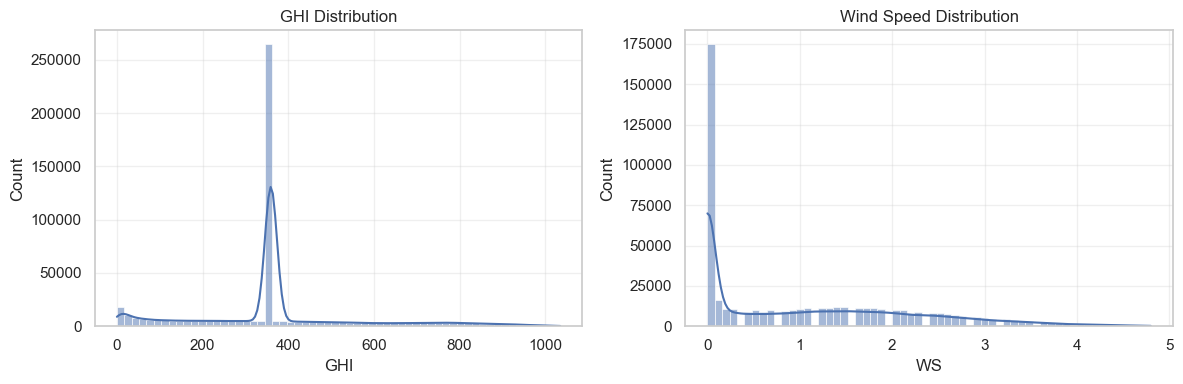

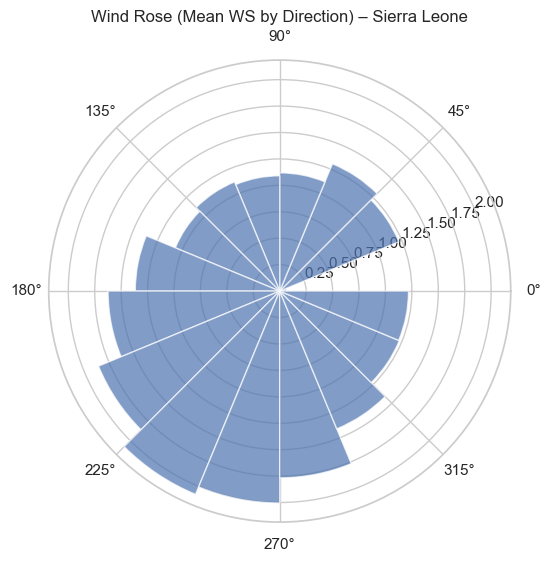

In [19]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(12,4))
if "GHI" in df_clean.columns:
    sns.histplot(df_clean["GHI"], bins=60, kde=True, ax=axes[0]); axes[0].set_title("GHI Distribution")
if "WS" in df_clean.columns:
    sns.histplot(df_clean["WS"], bins=60, kde=True, ax=axes[1]); axes[1].set_title("Wind Speed Distribution")
for ax in axes: ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Simple wind-rose style (polar histogram of WD, weighted by WS)
import numpy as np
if {"WD","WS"}.issubset(df_clean.columns):
    wd = np.deg2rad(df_clean["WD"].to_numpy())
    ws = df_clean["WS"].to_numpy()
    bins = np.linspace(0, 2*np.pi, 17)  # 16 sectors
    sector = np.digitize(wd, bins) - 1
    sector_mean_ws = [ws[sector==i].mean() if np.any(sector==i) else 0 for i in range(len(bins)-1)]

    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    theta = (bins[:-1] + bins[1:]) / 2
    ax.bar(theta, sector_mean_ws, width=(2*np.pi/16), bottom=0.0, alpha=0.7)
    ax.set_title("Wind Rose (Mean WS by Direction) – Sierra Leone")
    plt.show()


##  Temperature Analysis (Effect of Humidity)
Check how RH influences temperature and solar radiation.


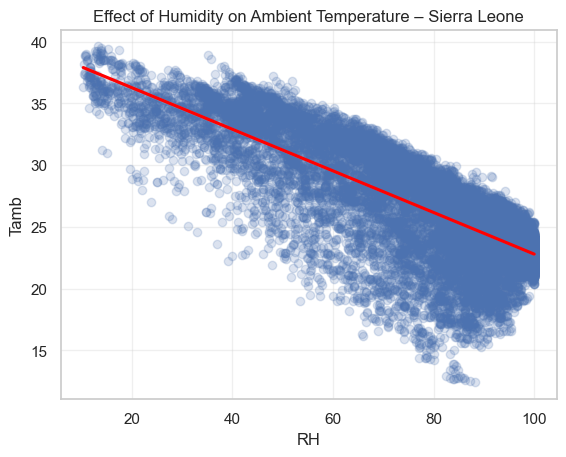

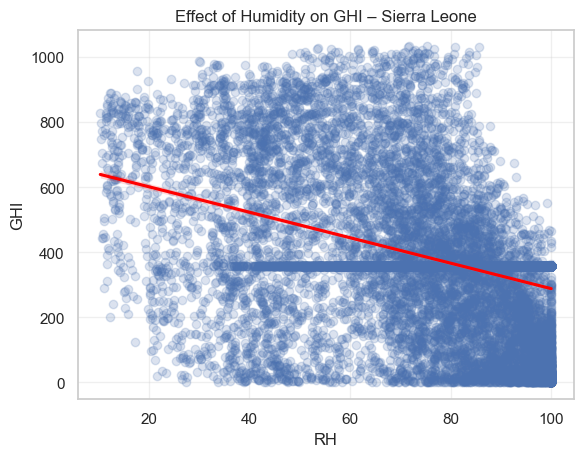

In [20]:
# Tamb vs RH (with regression line)
if {"RH","Tamb"}.issubset(df_clean.columns):
    sample = df_clean.sample(n=min(20000, len(df_clean)), random_state=42)
    sns.regplot(x="RH", y="Tamb", data=sample, scatter_kws={"alpha":0.2}, line_kws={"color":"red"})
    plt.title("Effect of Humidity on Ambient Temperature – Sierra Leone"); plt.grid(True, alpha=0.3); plt.show()

# GHI vs RH
if {"RH","GHI"}.issubset(df_clean.columns):
    sample = df_clean.sample(n=min(20000, len(df_clean)), random_state=42)
    sns.regplot(x="RH", y="GHI", data=sample, scatter_kws={"alpha":0.2}, line_kws={"color":"red"})
    plt.title("Effect of Humidity on GHI – Sierra Leone"); plt.grid(True, alpha=0.3); plt.show()


##  Bubble Chart – GHI vs Tamb (size & color = RH)


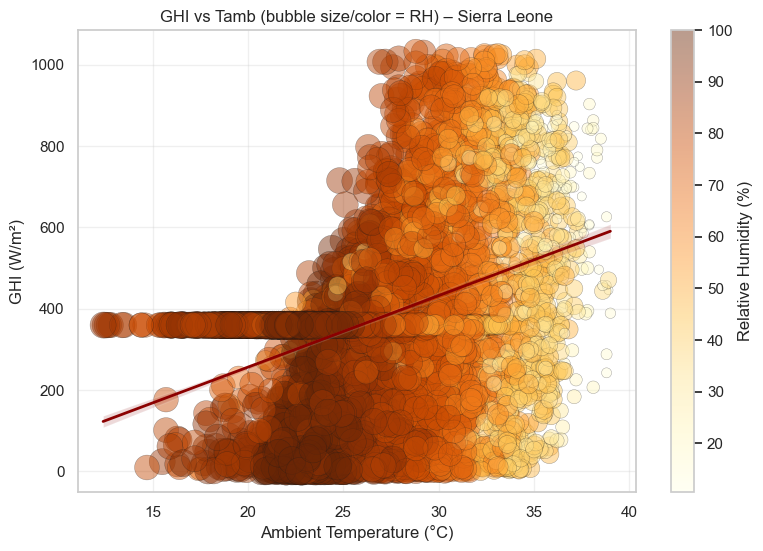

In [21]:
needed = {"Tamb","GHI","RH"}
if needed.issubset(df_clean.columns):
    sample = df_clean.sample(n=min(8000, len(df_clean)), random_state=42)
    plt.figure(figsize=(9,6))
    sc = plt.scatter(sample["Tamb"], sample["GHI"],
                     s=sample["RH"]*4, c=sample["RH"], cmap="YlOrBr",
                     alpha=0.45, edgecolors="k", linewidth=0.3)
    sns.regplot(x="Tamb", y="GHI", data=sample, scatter=False, color="darkred", line_kws={"linewidth":2})
    plt.colorbar(sc, label="Relative Humidity (%)")
    plt.title("GHI vs Tamb (bubble size/color = RH) – Sierra Leone")
    plt.xlabel("Ambient Temperature (°C)"); plt.ylabel("GHI (W/m²)")
    plt.grid(True, alpha=0.3); plt.show()


In [23]:
df_clean.to_csv("../data/sierra_leone_clean.csv", index=False)
print("✅ Saved: data/sierra_leone_clean.csv")


✅ Saved: data/sierra_leone_clean.csv
